<a href="https://colab.research.google.com/github/paigekan/Machine-Learning/blob/main/Week_7_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


# Pick your ticker and time period
stock_data = yf.download("NVDA", start="1999-01-22", end="2022-01-22")

# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)
# reshape(-1,1) > we provide column as 1 and row unknown
# numpy will return a new shape of (5788, 1) that is compatible with the original

# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]

[*********************100%***********************]  1 of 1 completed


In [4]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-22,0.437500,0.488281,0.388021,0.410156,0.376422,271468800
1999-01-25,0.442708,0.458333,0.410156,0.453125,0.415857,51048000
1999-01-26,0.458333,0.467448,0.411458,0.417969,0.383592,34320000
1999-01-27,0.419271,0.429688,0.395833,0.416667,0.382397,24436800
1999-01-28,0.416667,0.419271,0.412760,0.415365,0.381202,22752000
...,...,...,...,...,...,...
2022-01-14,263.000000,271.970001,262.100006,269.420013,269.168304,39583200
2022-01-18,262.600006,266.380005,257.700012,259.029999,258.787994,42427000
2022-01-19,260.790009,265.429993,250.520004,250.669998,250.435822,48831500


In [5]:
# Training data is the percentage change in daily closing price of stock
train_data

array([[ 0.10476255],
       [-0.07758568],
       [-0.003115  ],
       ...,
       [ 0.00211365],
       [ 0.00428417],
       [-0.00492223]])

# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [6]:
x_train = []
y_train = []

#Pick your input size and edit to make binary forecast
input_size = 3 # number of lags
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0]) 
    y_train.append(1 if train_data[i, 0] > 0 else 0)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

#Build Your RNN Architecture

# Initialize model
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1))) # LSTM Layer 1
model.add(LSTM(30, return_sequences=True))
model.add(LSTM(45, return_sequences=True))
model.add(LSTM(50, return_sequences=False)) # Final LSTM Layer
model.add(Dense(25)) # Neural Net Layer
# Include dropout percentage to help prevent overfitting (randomly sets certain % of inputs to 0 during training)
model.add(Dropout(0.15))
model.add(Dense(1, activation = 'sigmoid')) # Output layer

model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model.fit(x_train, y_train, batch_size=1, epochs=3)

Epoch 1/3
4627/4627 [==============================] - 42s 7ms/step - loss: 0.6945 - accuracy: 0.4912
Epoch 2/3
4627/4627 [==============================] - 33s 7ms/step - loss: 0.6940 - accuracy: 0.4956
Epoch 3/3
4627/4627 [==============================] - 33s 7ms/step - loss: 0.6937 - accuracy: 0.5057


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [7]:
test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
y_test_binary = np.where(y_test > 0, 1, 0) 
# Check if each element in y_test > 0, if yes then convert to 1, otherwise convert to 0

for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
# Convert output of logistic/sigmoid activation function to 0 or 1 using 0.5 threshold
pred_binary = (predictions > 0.5).astype(int)

37/37 [==============================] - 2s 4ms/step


In [8]:
y_test

array([[ 0.03759407],
       [-0.00146206],
       [ 0.01515058],
       ...,
       [-0.03227426],
       [-0.03658195],
       [-0.03213248]])

In [9]:
y_test_binary

array([[1],
       [0],
       [1],
       ...,
       [0],
       [0],
       [0]])

In [10]:
# In Sample Accuracy Method 1
from sklearn.metrics import accuracy_score

in_predictions = model.predict(x_train)
in_pred_binary = (in_predictions > 0.5).astype(int)

in_accuracy = accuracy_score(in_pred_binary, y_train)
in_accuracy

145/145 [==============================] - 1s 3ms/step


0.4940566241625243

In [11]:
# In Sample Accuracy Method 2
in_loss, in_accuracy = model.evaluate(x_train, y_train, batch_size = 1)
in_accuracy

4627/4627 [==============================] - 15s 3ms/step - loss: 0.6931 - accuracy: 0.4941


0.4940566122531891

In [12]:
# Out of Sample Accuracy
out_loss, out_accuracy = model.evaluate(x_test, y_test_binary, batch_size = 1)
out_accuracy

1158/1158 [==============================] - 5s 3ms/step - loss: 0.6932 - accuracy: 0.4585


0.45854923129081726

In [13]:
# In Sample Random Walk Accuracy
rw_in_actual = y_train[1:] # Actual
rw_in_pred = y_train[:-1] # Prediction
# All 0's # Prediction
rw_in_accuracy = accuracy_score(rw_in_pred, rw_in_actual)
rw_in_accuracy

0.49589277993947256

In [14]:
# Out of Sample Random Walk Accuracy
rw_out_actual = y_test_binary[1:] # actual
rw_out_pred = y_test_binary[:-1] # Prediction
rw_out_accuracy = accuracy_score(rw_out_pred, rw_out_actual)
rw_out_accuracy

0.4546240276577355

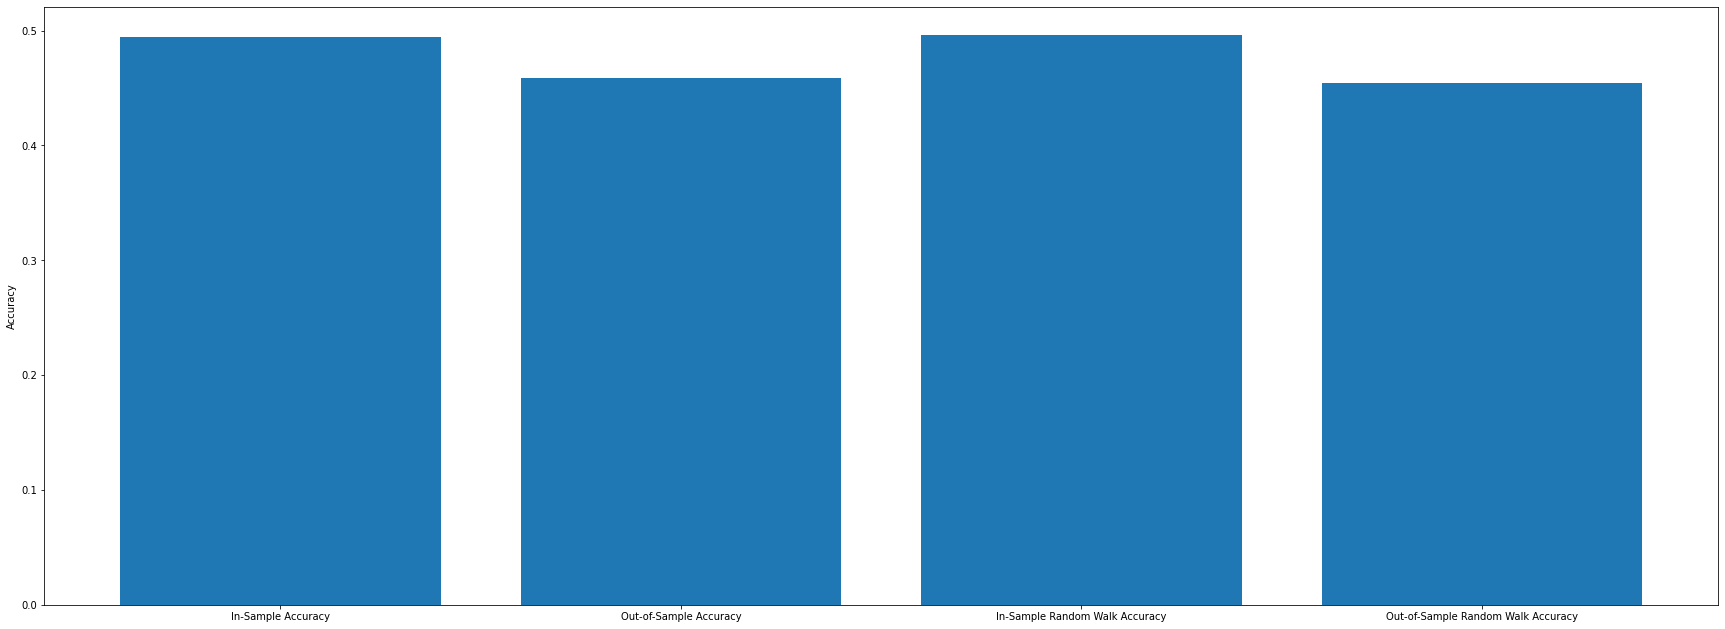

In [16]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (30,11))
plt.bar(
    ["In-Sample Accuracy", "Out-of-Sample Accuracy", "In-Sample Random Walk Accuracy", "Out-of-Sample Random Walk Accuracy"],
    [in_accuracy, out_accuracy, rw_in_accuracy, rw_out_accuracy],
    );

plt.ylabel("Accuracy")
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

When forecasting the direction of asset price movement using past price data, my model performed poorly in terms of accuracy. However, this poor performance is not similarly reflected in the plot of in and out of sample accuracy. In short, such plots can be quite misleading because they make our forecasts appear much more accurate than they actually are.

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [10]:
x_train = []
y_train = []

input_size = 3

for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0]) 
    y_train.append(1 if train_data[i, 0] > 0 else 0)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [11]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
def create_model(input_size):

    model = Sequential()
    model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(LSTM(30, return_sequences=True))
    model.add(LSTM(45, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dropout(0.15))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
param_grid = {'epochs': [1],
              'input_size': [5,10,15]}

# Perform the grid search over the hyperparameters
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    n_jobs=-1, 
    cv=3)

grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-11-7fd7b80e4a37>:20: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Best: 0.496003 using {'epochs': 1, 'input_size': 5}
